In [69]:
# Basic imports
import os
import sys
import pickle
from itertools import product
import warnings

# System path modification
sys.path.insert(0, '..')
sys.path.insert(0, './src')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from missforest import MissForest

# Statistic imports
from scipy.special import kl_div
from scipy.stats import ks_2samp, entropy, wasserstein_distance

# Custom modules
from src.gain import *
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *
from src.wrapper import *

# Visualizatiokn 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cmap import Colormap

# Ignore warnings
warnings.filterwarnings("ignore")

# Load data

In [70]:
data = load_pickle_data_palettes()

results_pickle_folder = "../pickle/"

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
dict_select = data["dict_select"]

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

# List Imputers

In [71]:
random_state=42
n_imputation_iter = 100

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}


# Define hyperparameters
gain_parameters_a = {
    'hint_rate': 0.9,
    'alpha': 10,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("SimpleImputer_mean", SimpleImputer(strategy="mean")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("KNNImputer_2", KNNImputer(n_neighbors=2)),
    ("KNNImputer_3", KNNImputer(n_neighbors=3)),
    ("KNNImputer_5", KNNImputer(n_neighbors=5)),
    ("IterativeImputer_1", IterativeImputer(max_iter=1, random_state=42)),
    ("IterativeImputer", IterativeImputer(max_iter=100, random_state=42)),
    ("MissForest", MissForest(max_iter=n_imputation_iter)),
    ("GAINImputer", GAINImputer(**gain_parameters)),
    ("GAINImputer_alpha", GAINImputer(**gain_parameters_a))
]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("SimpleImputer_most_frequent", SimpleImputer(strategy="most_frequent")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("SimpleImputer_constant", SimpleImputer(strategy="constant", fill_value=-1))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(continuous_imputer)
    print(ordinal_imputer)
    print(model)
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

('SimpleImputer_mean', SimpleImputer())
('SimpleImputer_most_frequent', SimpleImputer(strategy='most_frequent'))
('LinearRegression', LinearRegression())
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
('SimpleImputer_mean', SimpleImputer())
('KNNImputer', KNNImputer(n_neighbors=1))
('LinearRegression', LinearRegression())
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: KNNImputer, Model: LinearRegression
('SimpleImputer_mean', SimpleImputer())
('SimpleImputer_constant', SimpleImputer(fill_value=-1, strategy='constant'))
('LinearRegression', LinearRegression())
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
('KNNImputer', KNNImputer(n_neighbors=1))
('SimpleImputer_most_frequent', SimpleImputer(strategy='most_frequent'))
('LinearRegression', LinearRegression())
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegressio

# Compute imputed data distributions

In order to have a look at the features imputed by our different algorithms, we will just impute some of the data with the different algorithms on the training set with all the missing values to see if the distributions of imputed data do not diverge too much from the original ones. 

In [72]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

df_X_train = df_X.loc[idx_train]
df_X_test = df_X.loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

In [73]:
df_X_imputed_list = {"Original" : df_X_train}

ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']
continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

imputed_filename = "dict_imputed_df_X"

file_path = os.path.join(results_pickle_folder, f"{imputed_filename}.pickle")

if os.path.exists(file_path):
    print(f"The file '{imputed_filename}' already exists'.")
    with open(file_path, "rb") as file: 
        df_X_imputed_list = pd.read_pickle(file)
else:

    for imputer_name, continuous_imputer in continuous_imputer_list: 
        df_X_imputed = df_X_train.copy()

        continuous_imputer.fit(df_X_train[continuous_features])
        
        df_X_imputed[continuous_features] = continuous_imputer.transform(df_X_train[continuous_features])
        df_X_imputed_list[imputer_name] = df_X_imputed

    file_path = os.path.join(results_pickle_folder, f"{imputed_filename}.pickle")

    with open(file_path, 'wb') as file:
        pickle.dump(df_X_imputed_list, file)
    print(f"The dictionary has been saved as '{imputed_filename}.pkl' in the folder ''.")

The file 'dict_imputed_df_X' already exists'.


In [74]:
cols_to_check = ['ABETA', 'TAU', 'PTAU', 'CREB5', 'CLIC1', 'CD63']

imputed_X_lst = list(df_X_imputed_list.values())
imputed_name_lst = list(df_X_imputed_list.keys())

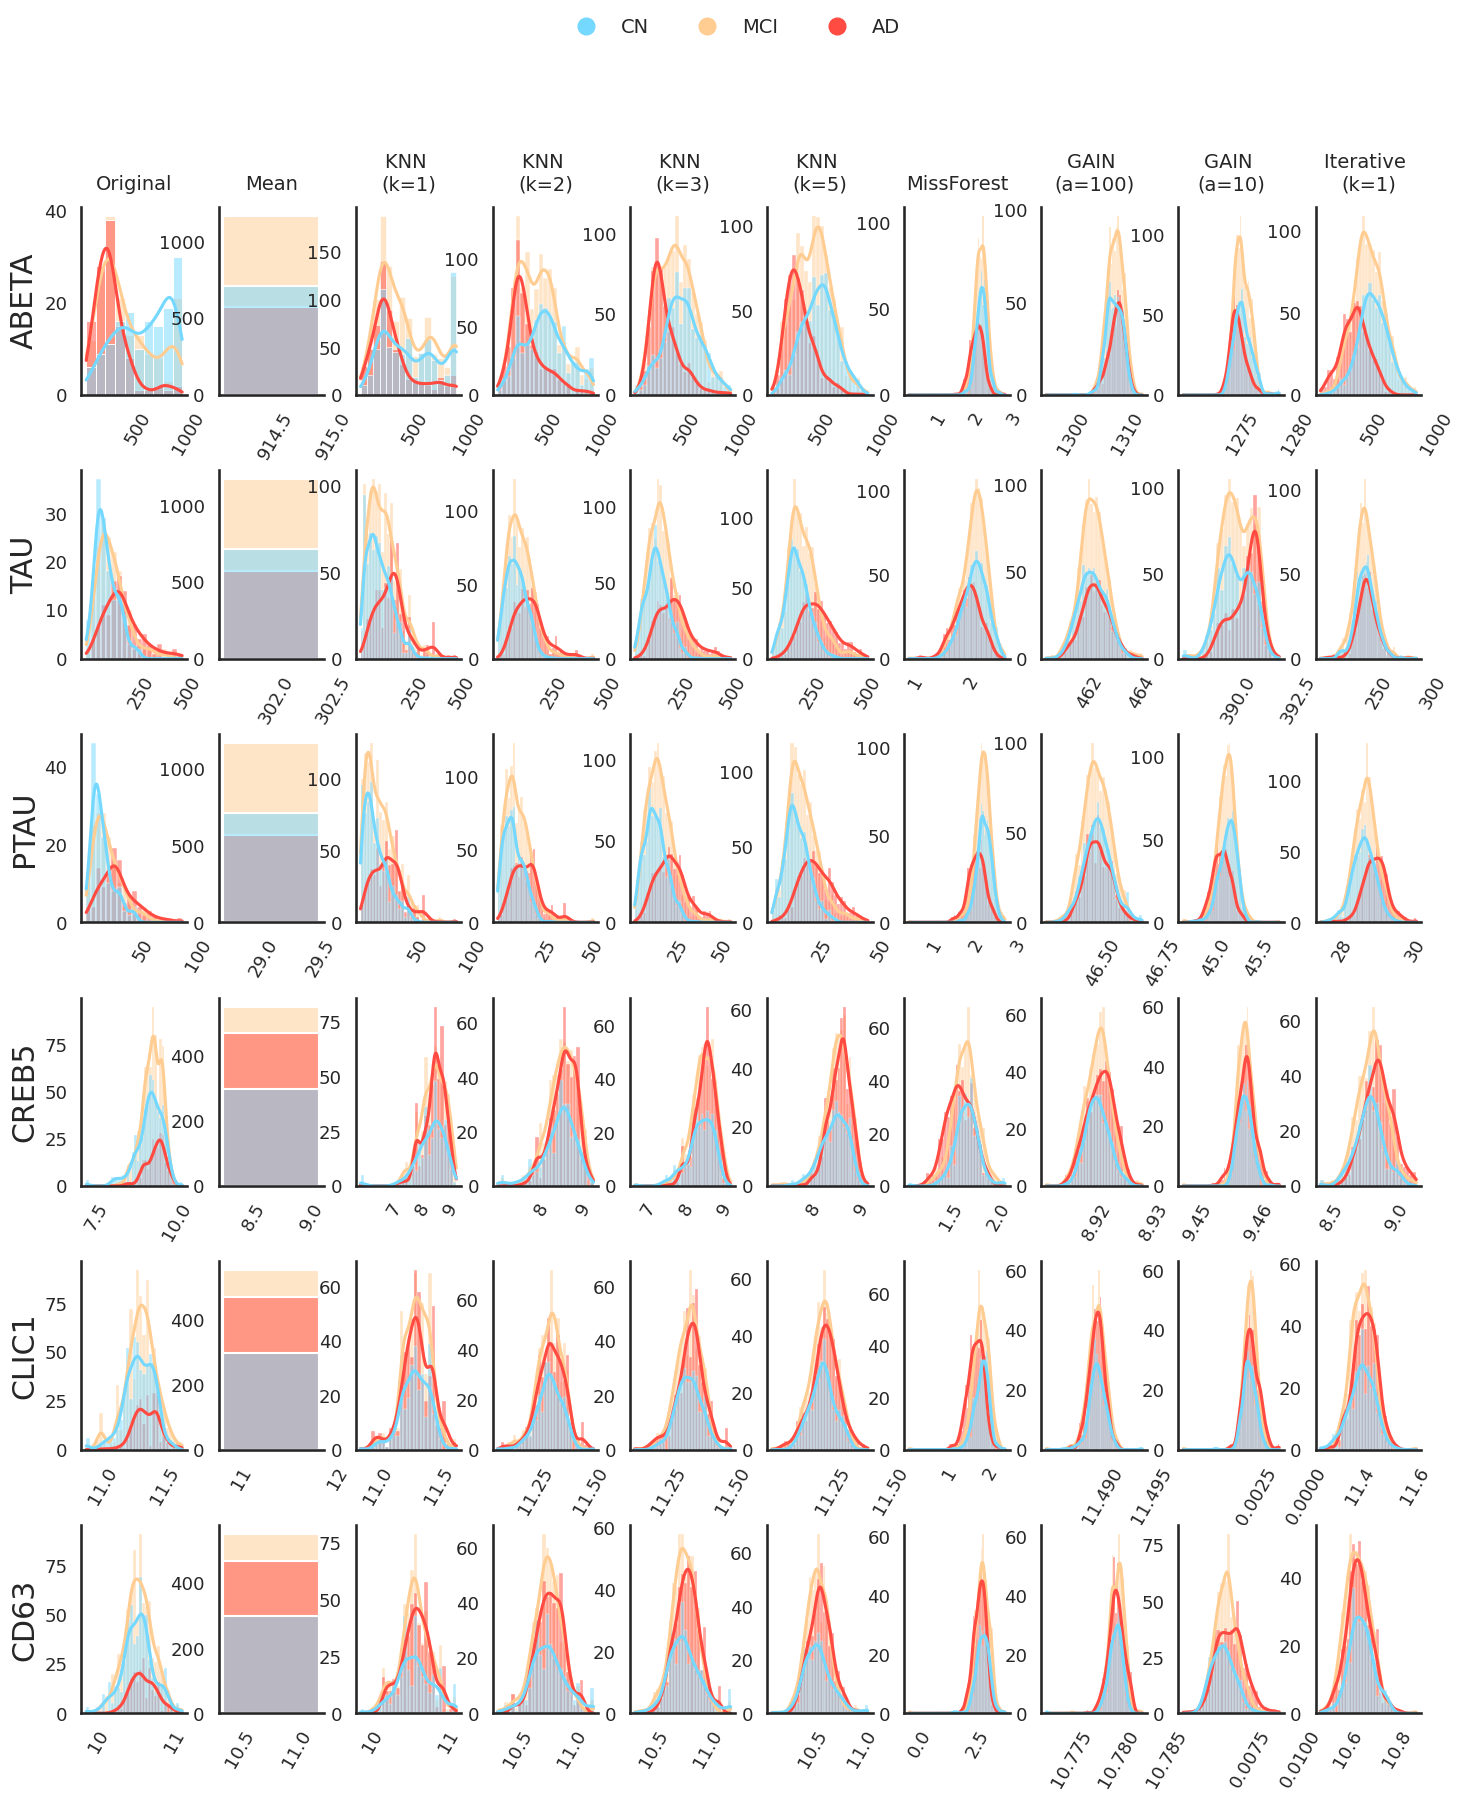

In [75]:
hue_col = df_all.DX[idx_train]
palette = dx_palette

new_names = {"SimpleImputer_mean": "Mean", 
"KNNImputer": "KNN (k=1)",
"KNNImputer_2": "KNN (k=2)", 
"KNNImputer_3": "KNN (k=3)",
"KNNImputer_5": "KNN (k=5)",
"GAINImputer" : "GAIN (a=100)",
"GAINImputer_alpha" : "GAIN (a=10)",
"IterativeImputer_1" : "Iterative (k=1)"
 }

sns.set_style("white")
sns.set_context("talk")

df_X0 = imputed_X_lst[0]

fig, axes = plt.subplots(nrows=len(cols_to_check), ncols=len(imputed_X_lst), figsize=(15, 18))
axes = np.array(axes)

original_ticks = {}

for i, plot_X in enumerate(imputed_X_lst):
    for j, col in enumerate(cols_to_check):
        if imputed_name_lst[i] != "Original":
            plot_X_filtered = plot_X[df_X0[col].isna()]
        else:
            plot_X_filtered = plot_X
            original_ticks[col] = [
                np.floor(plot_X[col].min()),
                np.floor((plot_X[col].min() + plot_X[col].max()) / 2),
                np.ceil(plot_X[col].max()),
            ]

        sns.histplot(
            plot_X_filtered,
            x=col,
            hue=hue_col,
            ax=axes[j][i],
            palette=palette,
            kde=(imputed_name_lst[i] != "SimpleImputer_mean"),
            legend=False,
        )

        axes[j][i].set_xlabel("")
        axes[j][i].set_ylabel("")
        axes[j][i].set_xticklabels(axes[j][i].get_xticklabels(), rotation=60, ha="left", fontsize=13)
        axes[j][i].set_yticklabels(axes[j][i].get_yticklabels(), ha="right", fontsize=13)
        axes[j][i].xaxis.set_major_locator(MaxNLocator(nbins=2, integer=True))
        axes[j][i].tick_params(pad=1)
        sns.despine()

# Set column titles with proper spacing
for ax, col in zip(axes[0], imputed_name_lst):
    display_col = new_names.get(col, col)  # Use mapped name if available
    ax.set_title(
        display_col.replace("(", "\n("),  # Optional: line break for better formatting
        pad=12,
        fontsize=14
    )

# Set row labels
for ax, col in zip(axes[:, 0], cols_to_check):
    ax.set_ylabel(col.replace("_", " "), rotation=90, size="large")

# Legend (centered above)
if palette is not None:
    handles = [
        mlines.Line2D([], [], color=color, marker="o", linestyle="", markersize=12, label=label)
        for label, color in palette.items()
    ]
    fig.legend(
        handles=handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.01),  # Bring legend closer
        ncol=len(palette),
        frameon=False,
        fontsize=14
    )

# Reduce space between plots and legend
plt.tight_layout(rect=[0, 0, 1, 0.94])  # Reserve top space for legend
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Save
plt.savefig("../figures/imputation_distribution_plots.png", format="png", bbox_inches="tight")
plt.show()


In [76]:
df_X_imputed_list
features_of_interest=cols_to_check
savefolder = "../figures/imputation"
heatmap_annot=True

original_df = df_X_imputed_list['Original']
ks_stats = {}
p_values = {}
kl_divergences = {}

In [77]:
def compute_imputation_stats(original_df, df_X_imputed_list, features_of_interest):
    ks_stats = {}
    p_values = {}
    kl_divergences = {}
    entropies = {}
    wasserstein_distances = {}
    ecdf_data_dict = {}

    for feature_name in features_of_interest:
        ks_stats[feature_name] = {}
        p_values[feature_name] = {}
        kl_divergences[feature_name] = {}
        entropies[feature_name] = {}
        wasserstein_distances[feature_name] = {}

        # Clean original (non-missing values)
        original_clean = original_df[feature_name].dropna()
        missing_indices = original_df[feature_name].isna()

        # Common histogram bins based on original
        bins = np.histogram_bin_edges(original_clean, bins="fd")

        # Histogram for original
        original_hist, _ = np.histogram(original_clean, bins=bins, density=True)
        original_hist += 1e-9  # smoothing
        original_hist /= original_hist.sum()  # normalize


        # ECDF container
        ecdf_data = pd.DataFrame()

        for method, imputed_df in df_X_imputed_list.items():
            if method == 'Original':
                continue

            imputed_values = imputed_df.loc[missing_indices, feature_name].dropna()

            # KS test
            ks_stat, p_value = ks_2samp(original_clean, imputed_values)
            ks_stats[feature_name][method] = ks_stat
            p_values[feature_name][method] = p_value

            # Histogram for imputed values
            imputed_hist, _ = np.histogram(imputed_values, bins=bins, density=True)
            imputed_hist += 1e-9
            imputed_hist /= imputed_hist.sum()

            # KL divergence
            kl_divergences[feature_name][method] = entropy(original_hist, imputed_hist, base=2, nan_policy='omit')

            # Wasserstein distance (directly on raw values)
            print(f"Calculating Wasserstein distance for {feature_name} using method {method}")
            print(original_clean.shape, imputed_values.shape)

            w_distance = wasserstein_distance(original_clean, imputed_values)
            wasserstein_distances[feature_name][method] = w_distance

            # ECDF
            temp_df = pd.DataFrame({
                'Value': np.sort(imputed_values),
                'ECDF': np.arange(len(imputed_values)) / len(imputed_values),
                'Method': method
            })
            ecdf_data = pd.concat([ecdf_data, temp_df], ignore_index=True)

        # ECDF for original
        original_ecdf = pd.DataFrame({
            'Value': np.sort(original_clean),
            'ECDF': np.arange(len(original_clean)) / len(original_clean),
            'Method': 'Original'
        })
        ecdf_data = pd.concat([ecdf_data, original_ecdf], ignore_index=True)

        ecdf_data_dict[feature_name] = ecdf_data

    return (
        ecdf_data_dict,
        ks_stats,
        p_values,
        kl_divergences,
        wasserstein_distances
    )

In [78]:
select_imputed_features = dict_select["RNA"]+dict_select["CSF"]
# Compute all ECDFs and stats
ecdf_data_dict, ks_stats, p_values, kl_divs,  wasserstein = compute_imputation_stats(original_df, df_X_imputed_list, select_imputed_features)

Calculating Wasserstein distance for LRRK2 using method SimpleImputer_mean
(1563,) (1318,)
Calculating Wasserstein distance for LRRK2 using method KNNImputer
(1563,) (1318,)
Calculating Wasserstein distance for LRRK2 using method KNNImputer_2
(1563,) (1318,)
Calculating Wasserstein distance for LRRK2 using method KNNImputer_3
(1563,) (1318,)
Calculating Wasserstein distance for LRRK2 using method KNNImputer_5
(1563,) (1318,)
Calculating Wasserstein distance for LRRK2 using method MissForest
(1563,) (1318,)
Calculating Wasserstein distance for LRRK2 using method GAINImputer
(1563,) (1318,)
Calculating Wasserstein distance for LRRK2 using method GAINImputer_alpha
(1563,) (1318,)
Calculating Wasserstein distance for LRRK2 using method IterativeImputer_1
(1563,) (1318,)
Calculating Wasserstein distance for MAPK14 using method SimpleImputer_mean
(1563,) (1318,)
Calculating Wasserstein distance for MAPK14 using method KNNImputer
(1563,) (1318,)
Calculating Wasserstein distance for MAPK14 usi

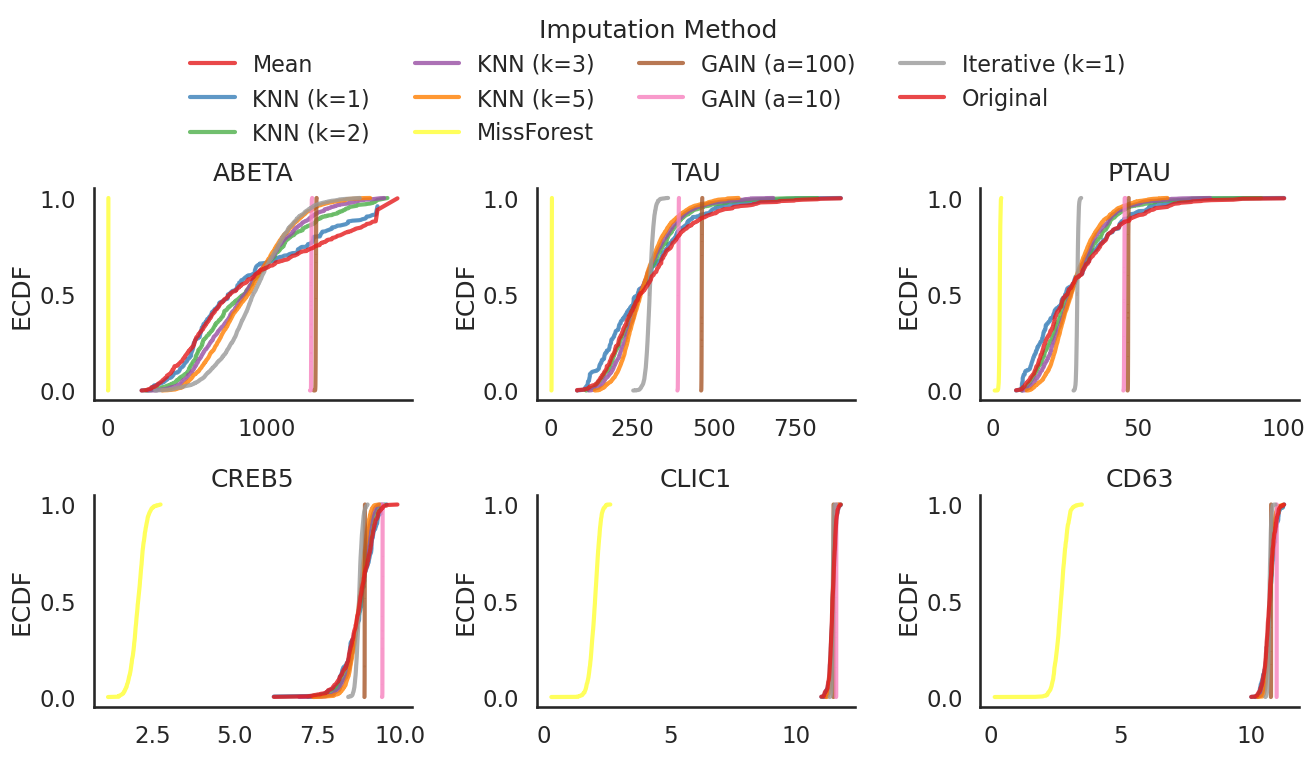

In [81]:
plot_ecdf_grid(ecdf_data_dict, features_of_interest=cols_to_check ,savefolder="../figures/imputation/ecdf")

In [82]:
# Convert results to DataFrames for heatmaps
ks_stats_df = pd.DataFrame(ks_stats).T.dropna()
p_values_df = pd.DataFrame(p_values).T.dropna()
kl_divergences_df = pd.DataFrame(kl_divs).T.dropna()
wasserstein_df = pd.DataFrame(wasserstein).T.dropna()

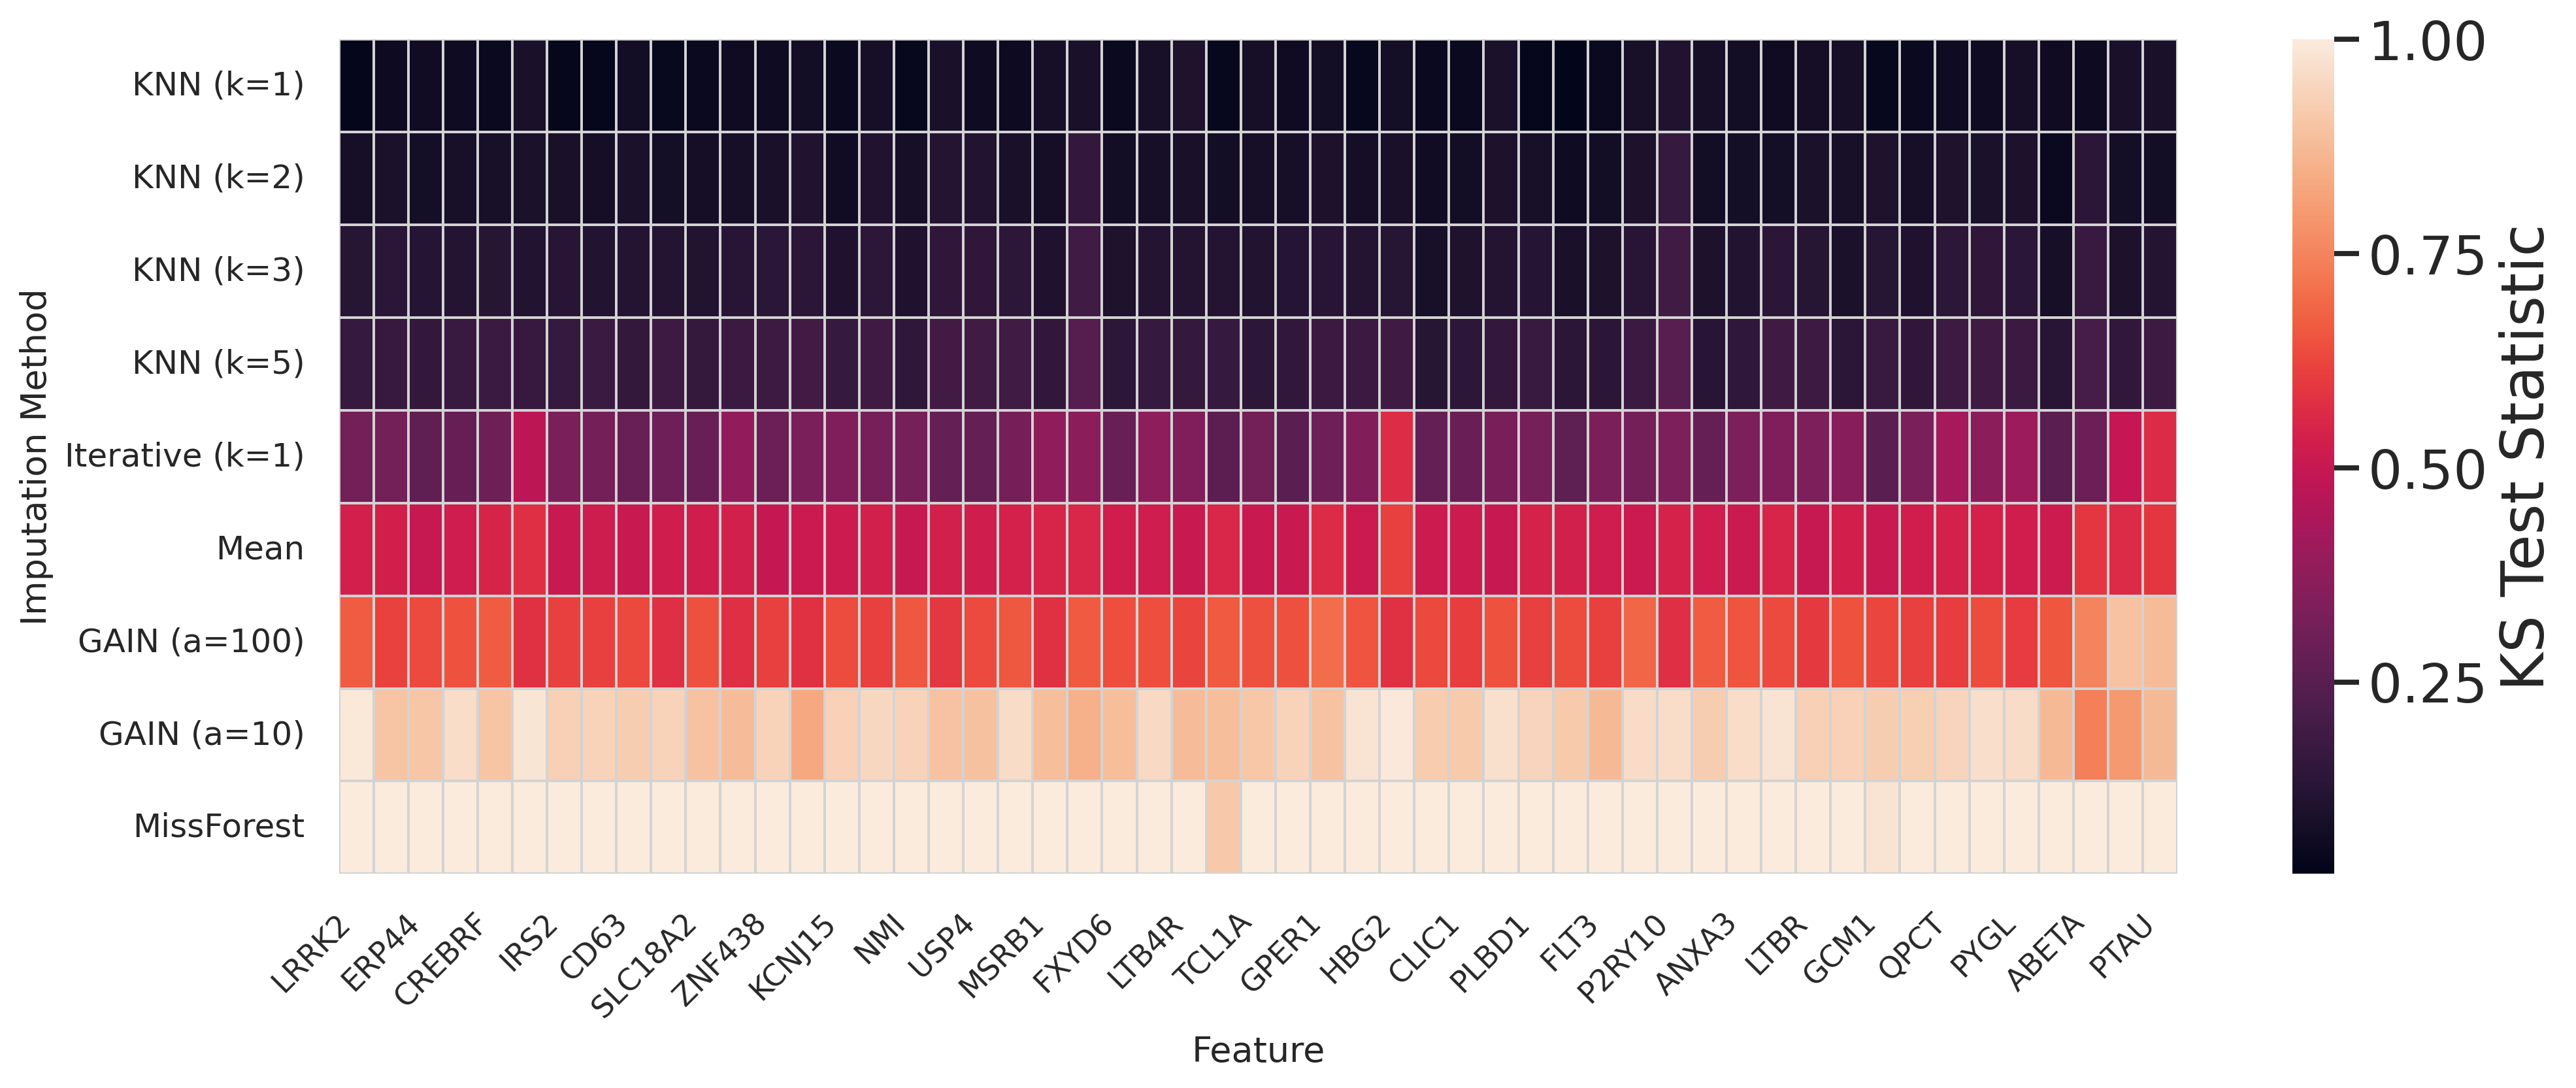

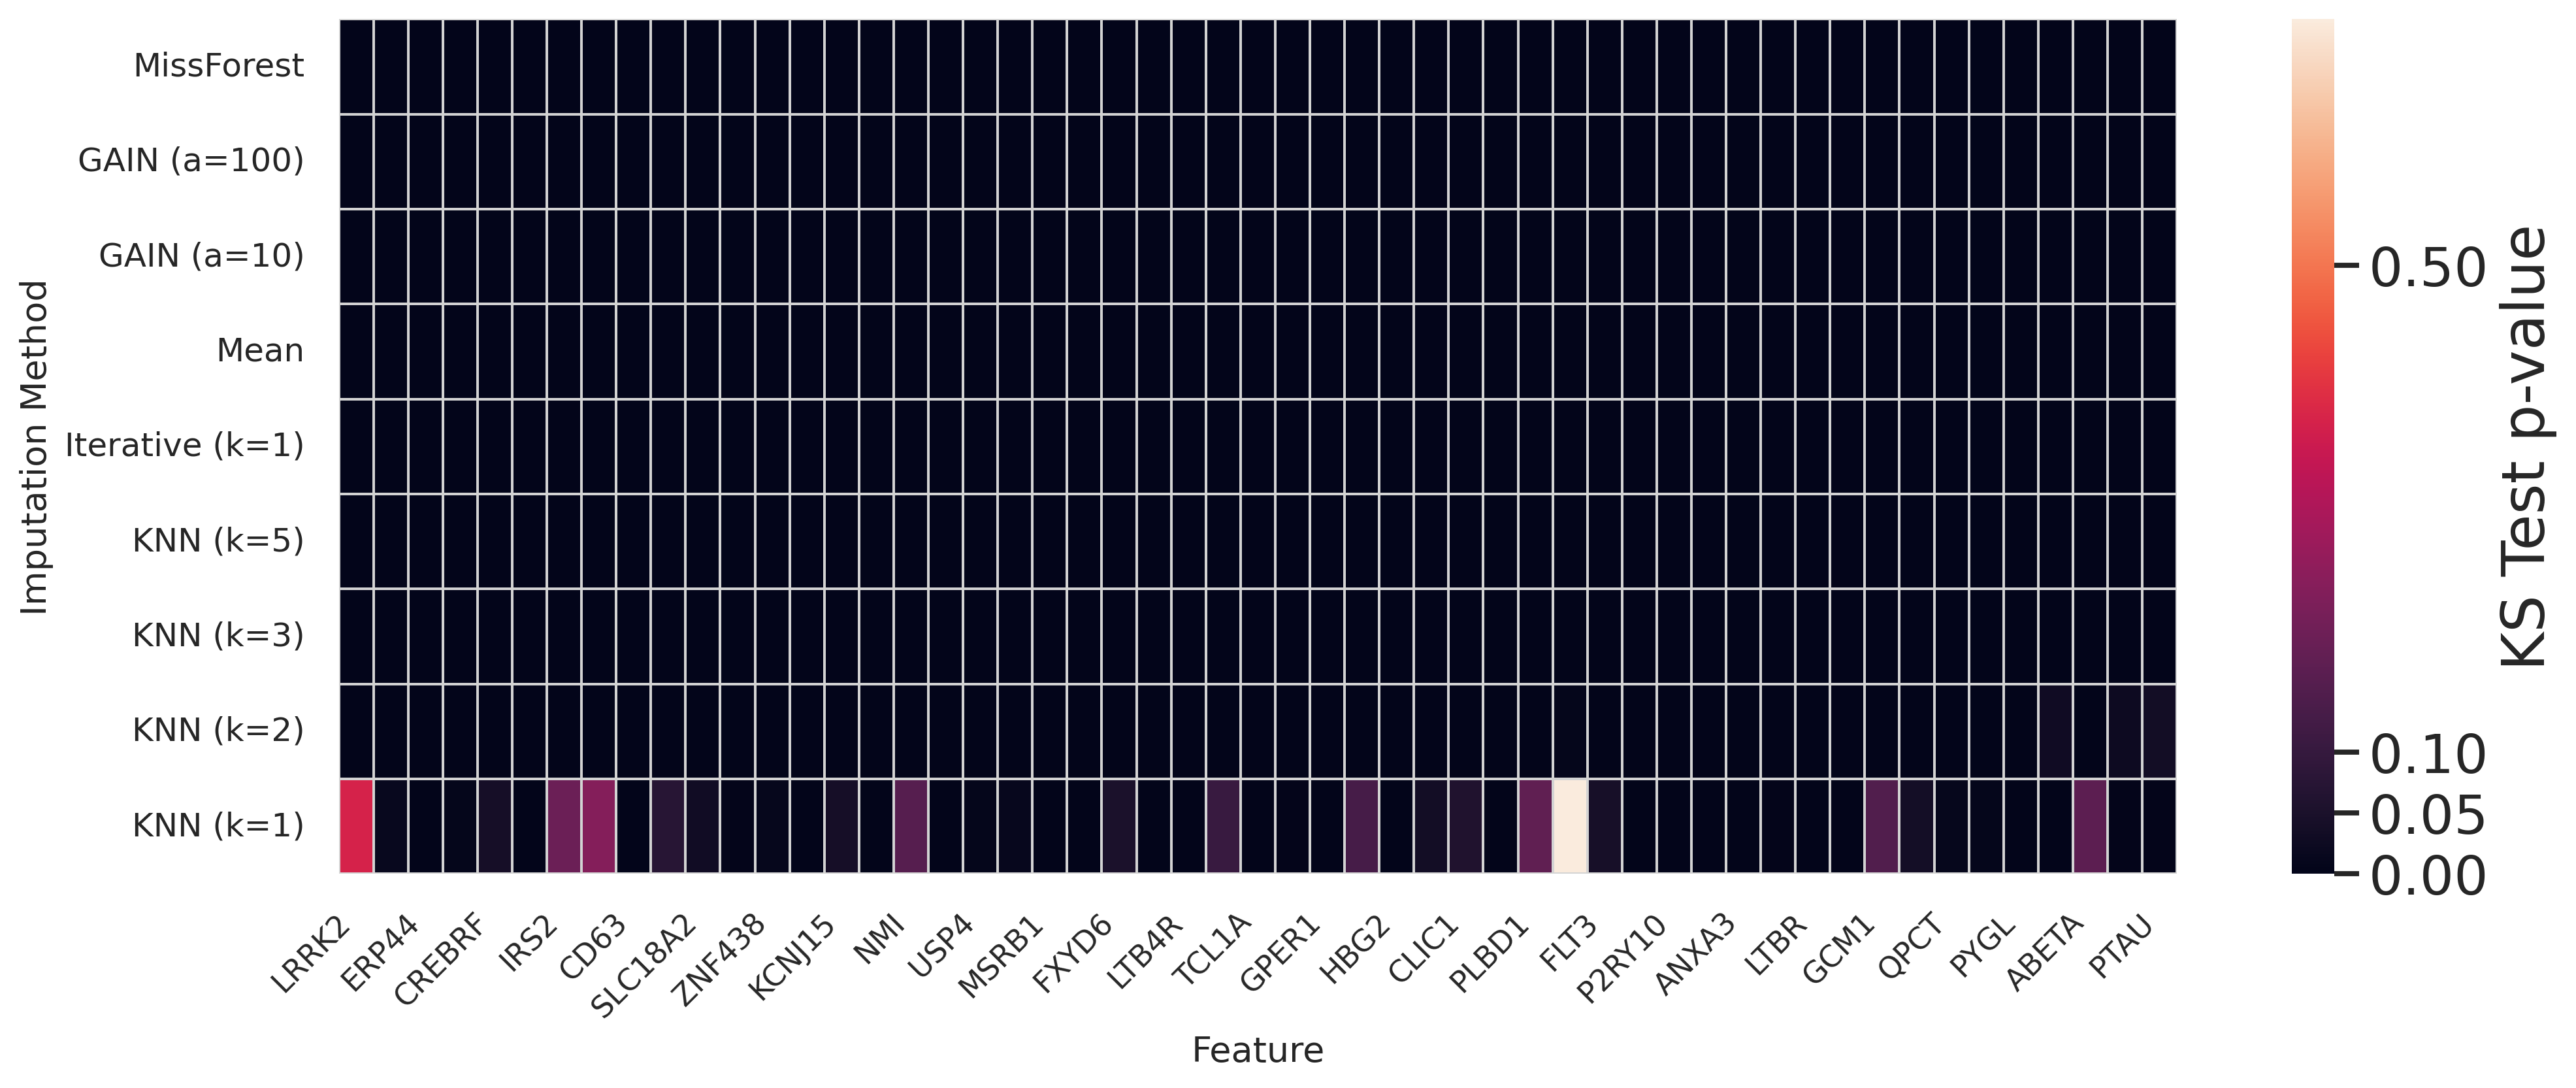

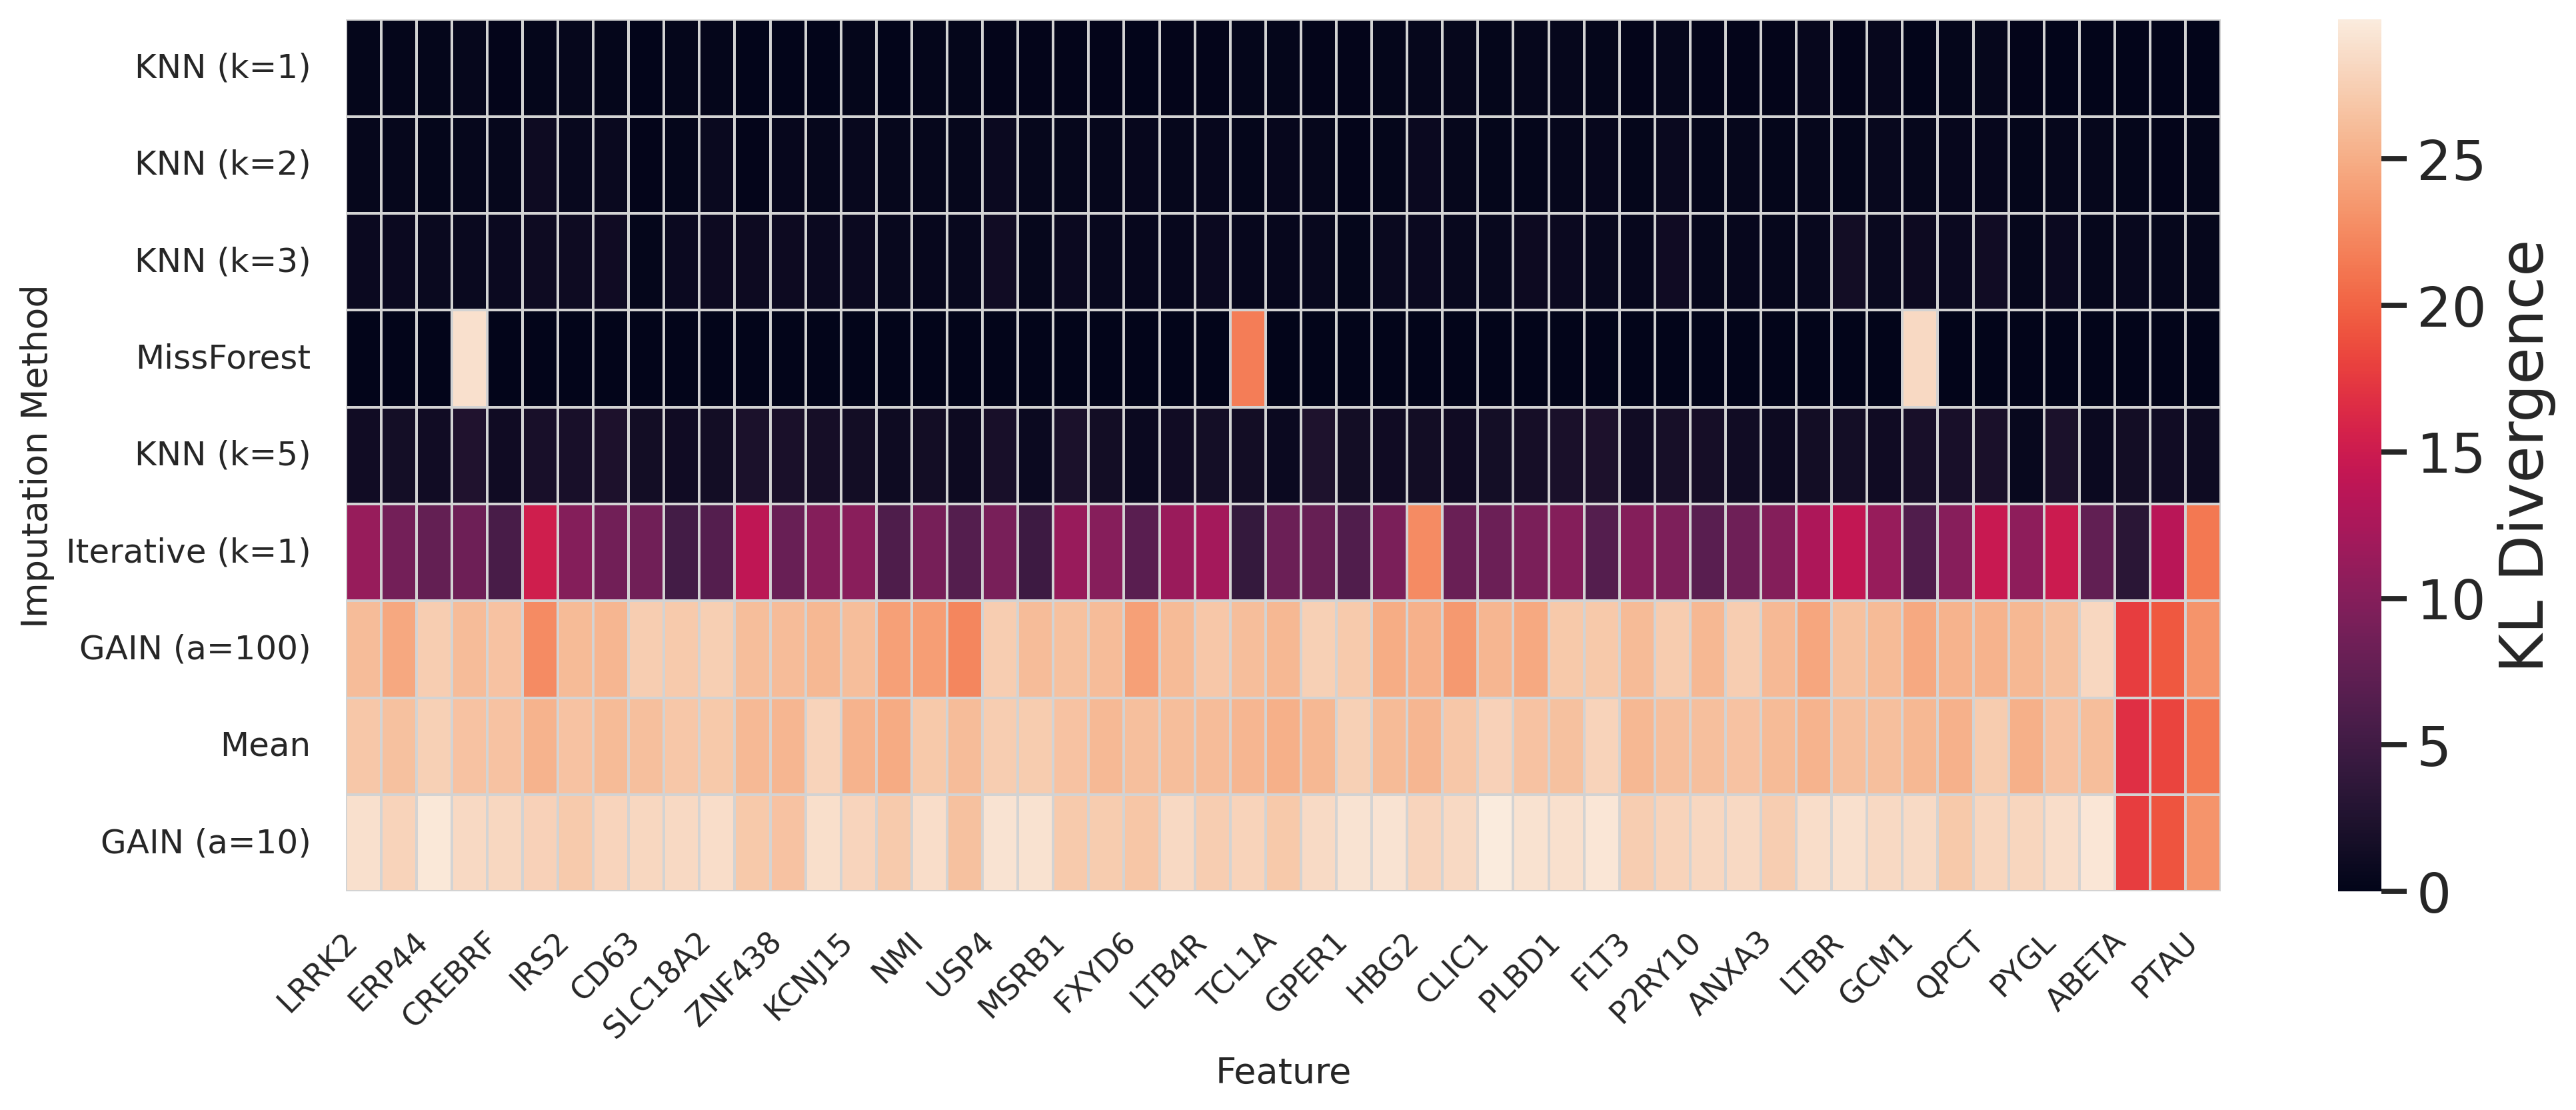

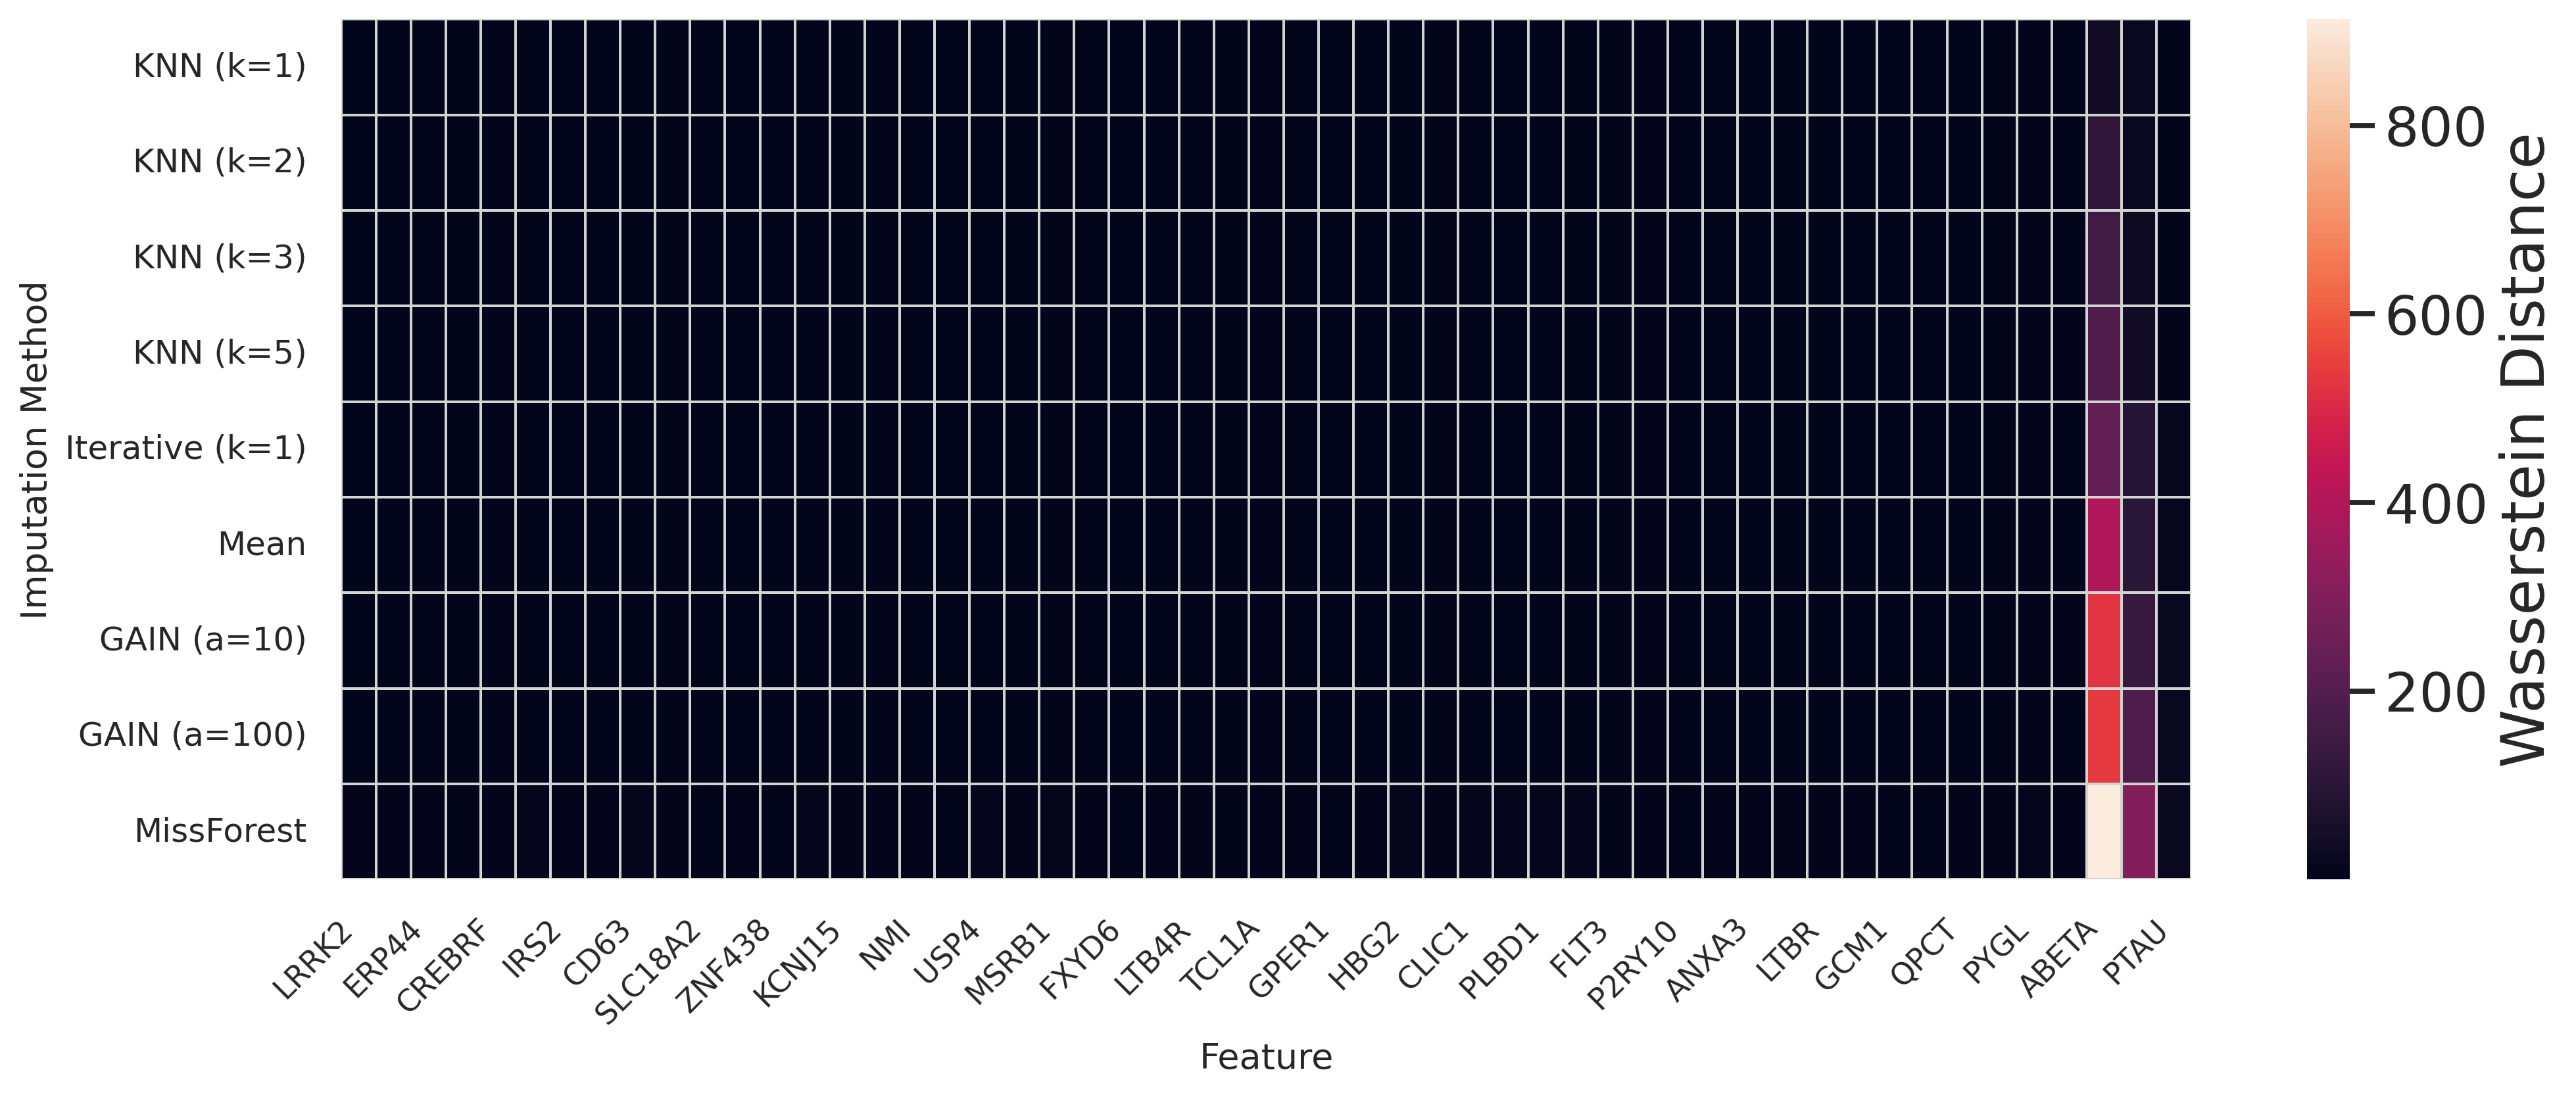

In [ ]:
# KS Statistic
plot_metric_heatmap(
    metric_df=ks_stats_df,
    metric_name="KS Test Statistic",
    imputer_names=new_names,
    features_of_interest=ks_stats_df.index,
    annotations_df=None,
    savefolder=savefolder,
    cmap="rocket",
    cbar_ticks=[0.0, 0.25, 0.5, 0.75, 1.0]
)

# P-values
plot_metric_heatmap(
    metric_df=p_values_df,
    metric_name="KS Test p-value",
    imputer_names=new_names,
    features_of_interest=p_values_df.index,
    annotations_df=None,
    savefolder=savefolder,
    cmap="rocket",
    cbar_ticks=[0.0, 0.05, 0.1, 0.5, 1.0]
)

# KL Divergence
plot_metric_heatmap(
    metric_df=kl_divergences_df,
    metric_name="KL Divergence",
    imputer_names=new_names,
    features_of_interest=kl_divergences_df.index,
    annotations_df=None,
    savefolder=savefolder,
    cmap="rocket",
)

# KL Divergence
plot_metric_heatmap(
    metric_df=wasserstein_df,
    metric_name="Wasserstein Distance",
    imputer_names=new_names,
    features_of_interest=wasserstein_df.index,
    annotations_df=None,
    savefolder=savefolder,
    cmap="rocket",
)

### Order columns by KL divergence and KS test

In [113]:
def average_multiple_metrics_by_group(metric_dfs, feature_groups, metric_names=None):
    """
    Averages multiple metric DataFrames across grouped features and returns a combined DataFrame
    with MultiIndex (metric name, modality) on rows.

    Parameters:
        metric_dfs (list of pd.DataFrame): Metric DataFrames with index=features and columns=methods.
        feature_groups (dict): Grouping of features per modality.
        metric_names (list of str, optional): Names corresponding to the metric_dfs. If None, will use indices.

    Returns:
        pd.DataFrame: Rows are (metric_name, modality), columns are imputation methods.
    """
    if metric_names is None:
        metric_names = [f"Metric_{i}" for i in range(len(metric_dfs))]

    combined_rows = []
    combined_index = []

    for metric_df, name in zip(metric_dfs, metric_names):
        avg_df = average_metrics_by_group(metric_df, feature_groups)
        combined_rows.append(avg_df)
        combined_index.extend([(name, idx) for idx in avg_df.index])

    # Concatenate and assign MultiIndex
    result_df = pd.concat(combined_rows)
    result_df.index = pd.MultiIndex.from_tuples(combined_index, names=["Metric", "Modality"])
    
    return result_df


In [114]:
selected_modalities = {x: dict_select[x] for x in ('RNA', 'CSF') if x in dict_select}

summary_df = average_multiple_metrics_by_group(
    metric_dfs=[ks_stats_df, p_values_df, kl_divergences_df, wasserstein_df],
    feature_groups=selected_modalities,
    metric_names=["KS-statistic", "KS-pvalue", "KL divergence", "Wasserstein distance"]
)

summary_df.T

Metric             KS-statistic                KS-pvalue                 \
Modality                    RNA       CSF            RNA            CSF   
SimpleImputer_mean     0.525515  0.581896  1.823708e-165  4.716619e-109   
KNNImputer             0.066542  0.080671   5.159984e-02   5.888022e-02   
KNNImputer_2           0.090190  0.096457   8.877371e-04   1.941343e-02   
KNNImputer_3           0.123380  0.129713   1.383501e-06   5.037374e-04   
KNNImputer_5           0.167492  0.182154   7.862206e-12   1.289218e-08   
MissForest             0.998118  1.000000   0.000000e+00  4.940656e-324   
GAINImputer            0.627482  0.841453  3.683905e-222  4.275870e-206   
GAINImputer_alpha      0.923755  0.802226   0.000000e+00  8.201206e-199   
IterativeImputer_1     0.325767  0.452092   4.978899e-43   5.180017e-29   

Metric             KL divergence            Wasserstein distance              
Modality                     RNA        CSF                  RNA         CSF  
SimpleImputer_mean     26.362173  18.769028             0.324766  169.230512  
KNNImputer              0.235432   0.075745             0.045837   19.217154  
KNNImputer_2            0.433864   0.225349             0.075771   46.880951  
KNNImputer_3            0.755954   0.484164             0.106863   63.441930  
KNNImputer_5            1.542290   1.294997             0.142420   79.285850  
MissForest              1.358304   0.000000             5.608921  413.144151  
GAINImputer            25.936670  20.086546             0.340927  247.322173  
GAINImputer_alpha      28.150989  20.009422             0.616446  225.264267  
IterativeImputer_1      9.532760  12.733850             0.250129  111.483085

# Select preprocessing and transforms using Linear Regression as evaluation  model

In [115]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

Some of the patients with no missing values in the test set are present in the training set so we will remove them from training. 

In [116]:
set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

In [117]:
for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

In [118]:
sum(idx_train) + sum(idx_test) == df_X.shape[0]

True

In [119]:
df_X_train = df_X.loc[idx_train]
df_X_test = df_X.loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']
continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

In [120]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("SimpleImputer_mean", SimpleImputer(strategy="mean")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("KNNImputer_2", KNNImputer(n_neighbors=2)),
    ("KNNImputer_3", KNNImputer(n_neighbors=3)),
    ("KNNImputer_5", KNNImputer(n_neighbors=5)),
    ("IterativeImputer", IterativeImputer(max_iter=n_imputation_iter, random_state=random_state)),
    ("IterativeImputer_Niter=1", IterativeImputer(max_iter=1, random_state=random_state)),
    ("MissForest", MissForestWrapper(max_iter=n_imputation_iter)),
    ("GAINImputer", GAINImputer(**gain_parameters)),
    ("GAINImputer_alpha", GAINImputer(**gain_parameters_a))
]


# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("SimpleImputer_most_frequent", SimpleImputer(strategy="most_frequent")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("SimpleImputer_constant", SimpleImputer(strategy="constant", fill_value=-1))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression())
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer_3, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imp

In [121]:
results_file = '../pickle/training_1_imputation_check_dict_results.pickle'

In [122]:
if os. path. exists(results_file):
    with open(results_file, "rb") as input_file:
        all_dict_results = pickle.load(input_file)
else : 
    all_dict_results = []

In [123]:
for continuous_imputer, ordinal_imputer, model in combinations:
    name_continuous_imputer, continuous_imputer_instance = continuous_imputer
    name_ordinal_imputer, ordinal_imputer_instance = ordinal_imputer
    name_model, model_instance = model

    params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : df_X_train.shape, 
        "test_shape": df_X_test.shape
    }

    if any(result['params'] == params for result in all_dict_results):
        # Skip this iteration if the combination exists
        print(f"Skipping existing combination: {params.values()}")
        
        continue

    try: 
        print(f"Computing combination: {params.values()}")
    
        # Now you can call your `train_model` function with these components
        dict_results = train_imputer_model(
            df_X_train, df_X_test, df_y_train, df_y_test,
            c_train, c_test,
            ordinal_imputer_instance, name_ordinal_imputer,
            continuous_imputer_instance, name_continuous_imputer,
            model_instance, name_model,
            separate_imputers=True  # Or however you want to specify
        )

    except Exception as e:  

        print(e)
    
        dict_results = {
        "params": params, 
        "imputation_time": None,
        "fitting_time": None, 
        "results_adj": None, 
        "results_org": None
    }
        
    print(dict_results)
        
    # Optionally keep the all_dict_results list updated
    all_dict_results.append(dict_results)

        # Save the updated results back to the pickle file
    with open(results_file, 'wb') as f:
        pickle.dump(all_dict_results, f)


Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'SimpleImputer_mean', 'LinearRegression', (2881, 256), (13, 256)])
Skipping existing combination: dict_values(['KNNImputer', 'SimpleImputer_mean', 'LinearRegression', (2881, 256), (13, 256)])
Skipping existing combination: dict_values(['SimpleImputer_constant', 'SimpleImputer_mean', 'LinearRegression', (2881, 256), (13, 256)])
Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'KNNImputer', 'LinearRegression', (2881, 256), (13, 256)])
Skipping existing combination: dict_values(['KNNImputer', 'KNNImputer', 'LinearRegression', (2881, 256), (13, 256)])
Skipping existing combination: dict_values(['SimpleImputer_constant', 'KNNImputer', 'LinearRegression', (2881, 256), (13, 256)])
Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'KNNImputer_2', 'LinearRegression', (2881, 256), (13, 256)])
Skipping existing combination: dict_values(['KNNImputer', 'KNNImputer_2', 'Linea

In [124]:
# Store data (serialize)
with open(results_file, 'wb') as handle: 
    pickle.dump(all_dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [125]:
with open(results_file, "rb") as input_file:
   dict_results_preprocessing = pickle.load(input_file)

In [126]:
df_results = pd.json_normalize(dict_results_preprocessing)

results_cols = df_results.columns[df_results.columns.str.startswith("results")]

In [127]:
def generate_metric_table(
    results_list,
    targets,
    metric_name,
    source="Adjusted",
    float_format="%.3f",
    csv_filename=None,
    sort_order="ascending"
):
    """
    Create a LaTeX and CSV table for a single metric across targets, models, and imputers,
    including mean ± std for performance, imputation time, and fitting time.

    Parameters
    ----------
    results_list : list of dict
        List of experiment results.
    targets : list of str
        Target names (e.g., ['ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN']).
    metric_name : str
        Metric to extract (e.g., 'mae_score').
    source : str
        'Adjusted' or 'Original'.
    float_format : str
        Format for floats (e.g., '%.3f').
    csv_filename : str or None
        If provided, saves the table to CSV.
    sort_order : str
        'ascending' or 'descending' for sorting by mean.

    Returns
    -------
    df : pd.DataFrame
        Final formatted DataFrame.
    latex_table : str
        LaTeX-formatted table string.
    """
    rows = []
    version_key = "results_adj" if source.lower() == "adjusted" else "results_org"

    for res in results_list:
        result_block = res.get(version_key)
        if result_block is None:
            continue

        metric_values = result_block.get(metric_name)
        if metric_values is None:
            continue

        if len(metric_values) != len(targets):
            continue

        ordinal_imputer = res["params"].get("ordinal_imputer")
        continuous_imputer = res["params"].get("continuous_imputer")
        model = res["params"].get("model")

        values = np.array(metric_values, dtype=np.float64)
        mean_val = np.mean(values)
        std_val = np.std(values)

        # Time metrics
        imp_times = np.array(res.get("imputation_time", []), dtype=np.float64)
        fit_times = np.array(res.get("fitting_time", []), dtype=np.float64)

        row = {
            "Ordinal Imputer": ordinal_imputer,
            "Continuous Imputer": continuous_imputer,
            "Model": model,
            "Mean": mean_val,
            "Mean ± SD": f"{mean_val:.3f} ± {std_val:.3f}",
            "Imputation Time": f"{imp_times.mean():.2f}" if imp_times.size > 0 else "N/A",
            "Fitting Time": f"{fit_times.mean():.2f}" if fit_times.size > 0 else "N/A"
        }

        row.update({target: val for target, val in zip(targets, values)})
        rows.append(row)

    df = pd.DataFrame(rows)

    # Reorder columns for display
    display_cols = (
        ["Ordinal Imputer", "Continuous Imputer", "Model"] +
        targets +
        ["Mean ± SD", "Imputation Time", "Fitting Time"]
    )
    df = df.sort_values(by="Mean", ascending=(sort_order == "ascending"))
    df = df[display_cols]

    # Save CSV if requested
    if csv_filename:
        df.to_csv(csv_filename, index=False)

    # Generate LaTeX table
    latex_table = df.to_latex(
        index=False,
        escape=False,
        float_format=float_format,
        caption=f"{metric_name.replace('_', ' ').upper()} across targets with timing info",
        label=f"tab:{metric_name}",
        longtable=False
    )

    return df, latex_table


In [128]:
dict_results_preprocessing

[{'params': {'ordinal_imputer': 'SimpleImputer_most_frequent',
   'continuous_imputer': 'SimpleImputer_mean',
   'model': 'LinearRegression',
   'train_shape': (2881, 256),
   'test_shape': (13, 256)},
  'imputation_time': 0.013779401779174805,
  'fitting_time': 0.10330891609191895,
  'results_adj': {'mse_score': array([0.84989115, 0.53759727, 0.59659968, 0.7991526 ]),
   'mae_score': array([0.6925139 , 0.58911593, 0.67673515, 0.73091122]),
   'r2': array([ 0.14103376,  0.38996661, -0.2456687 ,  0.02789418]),
   'explained_variance': array([ 0.19538547,  0.40827187, -0.24398795,  0.1932377 ]),
   'corr': array([0.50836909, 0.64414323, 0.1138735 , 0.49884408])},
  'results_org': {'mse_score': array([0.84989114, 0.53759726, 0.5965997 , 0.79915258]),
   'mae_score': array([0.6925139 , 0.58911593, 0.67673516, 0.73091121]),
   'r2': array([ 0.09593484,  0.39774271, -0.16198659,  0.06563741]),
   'explained_variance': array([ 0.15314022,  0.41581464, -0.16041876,  0.22456126]),
   'corr': ar

In [129]:
latex_df, latex_mae = generate_metric_table(
    results_list=dict_results_preprocessing,
    targets=['ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN'],
    metric_name='corr',
    source="Adjusted",
    csv_filename="../tables/1_training_imputation_corr_adjusted_sorted.csv",
    sort_order="descending"
)
print(latex_mae)

\begin{table}
\caption{CORR across targets with timing info}
\label{tab:corr}
\begin{tabular}{lllrrrrlll}
\toprule
Ordinal Imputer & Continuous Imputer & Model & ADNI_MEM & ADNI_EF & ADNI_VS & ADNI_LAN & Mean ± SD & Imputation Time & Fitting Time \\
\midrule
KNNImputer & IterativeImputer_Niter=1 & LinearRegression & 0.515 & 0.699 & 0.236 & 0.519 & 0.492 ± 0.166 & 100.14 & 0.08 \\
SimpleImputer_most_frequent & IterativeImputer_Niter=1 & LinearRegression & 0.526 & 0.698 & 0.219 & 0.519 & 0.491 ± 0.173 & 97.20 & 0.15 \\
SimpleImputer_constant & IterativeImputer_Niter=1 & LinearRegression & 0.513 & 0.696 & 0.232 & 0.509 & 0.488 ± 0.166 & 97.95 & 0.09 \\
KNNImputer & IterativeImputer & LinearRegression & 0.504 & 0.682 & 0.176 & 0.584 & 0.487 ± 0.190 & 900.78 & 0.11 \\
SimpleImputer_most_frequent & IterativeImputer & LinearRegression & 0.515 & 0.682 & 0.152 & 0.586 & 0.484 ± 0.201 & 955.43 & 0.20 \\
SimpleImputer_constant & IterativeImputer & LinearRegression & 0.503 & 0.680 & 0.169 & 0.576 

In [130]:
latex_df, latex_mae = generate_metric_table(
    results_list=dict_results_preprocessing,
    targets=['ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN'],
    metric_name='r2',
    source="Adjusted",
    csv_filename="../tables/1_training_imputation_r2_adjusted_sorted.csv",
    sort_order="ascending"
)
print(latex_mae)

\begin{table}
\caption{R2 across targets with timing info}
\label{tab:r2}
\begin{tabular}{lllrrrrlll}
\toprule
Ordinal Imputer & Continuous Imputer & Model & ADNI_MEM & ADNI_EF & ADNI_VS & ADNI_LAN & Mean ± SD & Imputation Time & Fitting Time \\
\midrule
SimpleImputer_most_frequent & MissForest & LinearRegression & -57472.898 & -71044.594 & -18360.075 & -23175.769 & -42513.334 ± 22333.510 & 304.51 & 0.20 \\
SimpleImputer_constant & MissForest & LinearRegression & -57058.762 & -71963.726 & -18728.861 & -22269.742 & -42505.273 ± 22662.739 & 305.43 & 0.21 \\
KNNImputer & MissForest & LinearRegression & -57077.158 & -71155.385 & -18618.247 & -23132.411 & -42495.800 ± 22243.349 & 301.06 & 0.08 \\
SimpleImputer_most_frequent & KNNImputer_2 & LinearRegression & 0.062 & 0.399 & -0.158 & -0.137 & 0.041 ± 0.224 & 2.05 & 0.20 \\
KNNImputer & KNNImputer_2 & LinearRegression & 0.050 & 0.400 & -0.144 & -0.139 & 0.042 ± 0.221 & 2.18 & 0.10 \\
SimpleImputer_constant & KNNImputer_2 & LinearRegression &

In [131]:
latex_df, latex_mae = generate_metric_table(
    results_list=dict_results_preprocessing,
    targets=['ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN'],
    metric_name='mae_score',
    source="Adjusted",
    csv_filename="../tables/1_training_imputation_mae_adjusted_sorted.csv",
    sort_order="ascending"
)
print(latex_mae)

\begin{table}
\caption{MAE SCORE across targets with timing info}
\label{tab:mae_score}
\begin{tabular}{lllrrrrlll}
\toprule
Ordinal Imputer & Continuous Imputer & Model & ADNI_MEM & ADNI_EF & ADNI_VS & ADNI_LAN & Mean ± SD & Imputation Time & Fitting Time \\
\midrule
KNNImputer & IterativeImputer & LinearRegression & 0.722 & 0.570 & 0.642 & 0.650 & 0.646 ± 0.054 & 900.78 & 0.11 \\
SimpleImputer_most_frequent & IterativeImputer & LinearRegression & 0.717 & 0.570 & 0.648 & 0.649 & 0.646 ± 0.052 & 955.43 & 0.20 \\
SimpleImputer_constant & IterativeImputer & LinearRegression & 0.730 & 0.572 & 0.644 & 0.655 & 0.650 ± 0.056 & 896.19 & 0.06 \\
KNNImputer & IterativeImputer_Niter=1 & LinearRegression & 0.705 & 0.554 & 0.626 & 0.748 & 0.658 ± 0.074 & 100.14 & 0.08 \\
KNNImputer & KNNImputer_5 & LinearRegression & 0.699 & 0.541 & 0.631 & 0.765 & 0.659 ± 0.083 & 2.61 & 0.06 \\
SimpleImputer_most_frequent & IterativeImputer_Niter=1 & LinearRegression & 0.700 & 0.555 & 0.634 & 0.748 & 0.659 ± 0.07

In [132]:
latex_df, latex_mse = generate_metric_table(
    results_list=dict_results_preprocessing,
    targets=['ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN'],
    metric_name='mse_score',
    source="Adjusted",
    csv_filename="../tables/1_training_imputation_mse_adjusted_sorted.csv",
    sort_order="ascending"
)
print(latex_mse)

\begin{table}
\caption{MSE SCORE across targets with timing info}
\label{tab:mse_score}
\begin{tabular}{lllrrrrlll}
\toprule
Ordinal Imputer & Continuous Imputer & Model & ADNI_MEM & ADNI_EF & ADNI_VS & ADNI_LAN & Mean ± SD & Imputation Time & Fitting Time \\
\midrule
SimpleImputer_most_frequent & IterativeImputer & LinearRegression & 0.877 & 0.486 & 0.536 & 0.664 & 0.641 ± 0.151 & 955.43 & 0.20 \\
KNNImputer & IterativeImputer & LinearRegression & 0.891 & 0.485 & 0.526 & 0.666 & 0.642 ± 0.159 & 900.78 & 0.11 \\
SimpleImputer_constant & IterativeImputer & LinearRegression & 0.894 & 0.488 & 0.530 & 0.674 & 0.647 ± 0.159 & 896.19 & 0.06 \\
SimpleImputer_most_frequent & IterativeImputer_Niter=1 & LinearRegression & 0.834 & 0.464 & 0.530 & 0.788 & 0.654 ± 0.160 & 97.20 & 0.15 \\
KNNImputer & IterativeImputer_Niter=1 & LinearRegression & 0.849 & 0.463 & 0.522 & 0.788 & 0.656 ± 0.166 & 100.14 & 0.08 \\
SimpleImputer_constant & GAINImputer_alpha & LinearRegression & 0.817 & 0.536 & 0.587 & 0.